In [2]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})

In [122]:
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection as model_selection
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.preprocessing import StandardScaler
# models
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix

In [4]:
def stddev_idslices_fun(row):
    # given an array of aquisitions, it return the std of activated slices
    # it create a populaion of slice ids, and compute stddev on them
    id_population = [item for id_list in [[i] * int(row[i]) for i in range(len(row))] for item in id_list]
    if id_population:    # check if the list of slice ids is not empty
        return np.std(id_population)
    else:
        return -1

In [5]:
def produce_quadrant_features(df, nshiftings=4):
    # split aquisitions in K "shifted" quadrant
    nslices = 72
    quadrant_width = nslices // 2   # idea: spread is within 30 slices (it depends on the sampling trick)
    shift = nslices // nshiftings   # derived
    df = df.iloc[:, 2:nslices+2]   # skip the first two fields (edep, pedetected)
    # create quadrants
    df_quadrants = []
    for i_shift in range(nshiftings):
        assert(i_shift*shift < nslices)
        quadrant = df.iloc[:, i_shift*shift:i_shift*shift + quadrant_width]
        if i_shift*shift + quadrant_width >= nslices:
            quadrant = pd.concat([quadrant, df.iloc[:, :i_shift*shift + quadrant_width - nslices]], axis=1)
        df_quadrants.append(quadrant)
    # compute stddev and meanPE for each quadrant
    for quadrant in df_quadrants:
        quadrant["stdslices"] = quadrant.apply(stddev_idslices_fun, axis=1)
        quadrant["meanpe"] = quadrant.apply(lambda row: row[:36].mean(), axis=1)
    # aggregate the features in a single dataset
    features = pd.DataFrame()
    for i, quadrant in enumerate(df_quadrants):
        features = pd.concat([features, quadrant[["stdslices", "meanpe"]]], axis=1)
    features.columns = ["{}_{}".format(col, j) for j in range(len(df_quadrants)) for col in ["stdslices", "meanpe"]]
    return features

In [6]:
filein = os.path.join("data", "Muons", "LowEnergyMuons_wt_0ar39_cut117PE.csv")
muons = pd.read_csv(filein, index_col=False)

filein = os.path.join("data", "Ar39", "dataset10000", "Ar39_1Pileup_cut117PE_n10000.csv")
ar39_1 = pd.read_csv(filein, index_col=False)
filein = os.path.join("data", "Ar39", "dataset10000", "Ar39_3Pileup_cut117PE_n10000.csv")
ar39_3 = pd.read_csv(filein, index_col=False)
filein = os.path.join("data", "Ar39", "dataset10000", "Ar39_5Pileup_cut117PE_n10000.csv")
ar39_5 = pd.read_csv(filein, index_col=False)
filein = os.path.join("data", "Ar39", "dataset10000", "Ar39_7Pileup_cut117PE_n10000.csv")
ar39_7 = pd.read_csv(filein, index_col=False)

print("[Info] Loaded {} low-energy muons, {} single Ar39".format(len(muons), len(ar39_1)))

[Info] Loaded 5176 low-energy muons, 10000 single Ar39


In [36]:
# data selection
# take the first 5200 ar39 to balance the two datasets -> the rest is hidden test set
ar39_1, test_ar39_1 = ar39_1.iloc[:5200, :], ar39_1.iloc[5200:, :]
ar39_3, test_ar39_3 = ar39_3.iloc[:5200, :], ar39_3.iloc[5200:, :]
ar39_5, test_ar39_5 = ar39_5.iloc[:5200, :], ar39_5.iloc[5200:, :]
ar39_7, test_ar39_7 = ar39_7.iloc[:5200, :], ar39_7.iloc[5200:, :]

In [37]:
muon_features = produce_quadrant_features(muons)
print("[Info] Computed features for muons")
ar39_1_features = produce_quadrant_features(ar39_1)
print("[Info] Computed features for 1 Ar39")
ar39_3_features = produce_quadrant_features(ar39_3)
print("[Info] Computed features for 3 Ar39")
ar39_5_features = produce_quadrant_features(ar39_5)
print("[Info] Computed features for 5 Ar39")
ar39_7_features = produce_quadrant_features(ar39_7)
print("[Info] Computed features for 7 Ar39")

/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[Info] Computed features for muons
[Info] Computed features for 1 Ar39
[Info] Computed features for 3 Ar39
[Info] Computed features for 5 Ar39
[Info] Computed features for 7 Ar39


In [43]:
# prepare data
# train easy model logistic regression
muon_features["y"] = 1
ar39_1_features["y"] = 0
ar39_3_features["y"] = 0
ar39_5_features["y"] = 0
ar39_7_features["y"] = 0
ar39_all_features = [ar39_1_features, ar39_3_features, ar39_5_features, ar39_7_features]


In [42]:
# define DTree model
names = ["DTree_{}Ar39".format(i+1) for i in range(0, 8, 2)]
dtree_maxdepth = 5
classifiers = [DecisionTreeClassifier(max_depth=dtree_maxdepth), DecisionTreeClassifier(max_depth=dtree_maxdepth), 
               DecisionTreeClassifier(max_depth=dtree_maxdepth), DecisionTreeClassifier(max_depth=dtree_maxdepth), 
               DecisionTreeClassifier(max_depth=dtree_maxdepth)]

In [120]:
import time
from sklearn.model_selection import KFold

model_template   = "[Info] Model: {}"
result_template  = "\t[Result] Iteration: {}: Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}"

cv_template      = "[Detail] Confusion Matrix:\n"
cv_template     += "\tAr39\tMu\n"
cv_template     += "\tPred\tPred\n"
cv_template     += "----------------------\n"
cv_template     += "Ar39\t{}\t{}\n"
cv_template     += "Mu\t{}\t{}\n"
cv_template     += "----------------------\n"
# Start kfold cross-validation
n_folds = 4
kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)

all_classifiers_evaluations = []
scalers = []
for name, clf, ar39_data in zip(names, classifiers, ar39_all_features):
    # data preparation
    data = pd.concat([muon_features, ar39_data], axis=0)
    X, y = data.iloc[:, :-1], data.iloc[:, -1]
    scalers.append(scaler)    # for later re-use
    X = np.array(X)
    y = np.array(y)
    # k-fold cross validation
    print(model_template.format(name))
    start = time.time()
    # iterate over classifiers
    accuracies, precisions, recalls = [], [], []
    iteration = 0
    for train_ids, test_ids in kf.split(X):
        iteration = iteration + 1
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = y[train_ids], y[test_ids]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        print(result_template.format(iteration, accuracies[-1], precisions[-1], recalls[-1]))
    print(result_template.format("AVG", np.mean(accuracies), np.mean(precisions), np.mean(recalls)))

[Info] Model: DTree_1Ar39
	[Result] Iteration: 1: Accuracy: 0.871, Precision: 0.890, Recall: 0.841
	[Result] Iteration: 2: Accuracy: 0.868, Precision: 0.885, Recall: 0.845
	[Result] Iteration: 3: Accuracy: 0.886, Precision: 0.900, Recall: 0.870
	[Result] Iteration: 4: Accuracy: 0.858, Precision: 0.893, Recall: 0.818
	[Result] Iteration: AVG: Accuracy: 0.871, Precision: 0.892, Recall: 0.843
[Info] Model: DTree_3Ar39
	[Result] Iteration: 1: Accuracy: 0.872, Precision: 0.890, Recall: 0.843
	[Result] Iteration: 2: Accuracy: 0.884, Precision: 0.914, Recall: 0.846
	[Result] Iteration: 3: Accuracy: 0.872, Precision: 0.900, Recall: 0.837
	[Result] Iteration: 4: Accuracy: 0.859, Precision: 0.871, Recall: 0.846
	[Result] Iteration: AVG: Accuracy: 0.872, Precision: 0.894, Recall: 0.843
[Info] Model: DTree_5Ar39
	[Result] Iteration: 1: Accuracy: 0.953, Precision: 0.955, Recall: 0.949
	[Result] Iteration: 2: Accuracy: 0.949, Precision: 0.954, Recall: 0.944
	[Result] Iteration: 3: Accuracy: 0.949, P

# Test trained model on further unseen data

In [99]:
filein = os.path.join("data", "Ar39", "dataset100000", "Ar39_1Pileup_cut117PE_n100000.csv")
test_ar39_1 = pd.read_csv(filein, index_col=False)
filein = os.path.join("data", "Ar39", "dataset100000", "Ar39_3Pileup_cut117PE_n100000.csv")
test_ar39_3 = pd.read_csv(filein, index_col=False)
filein = os.path.join("data", "Ar39", "dataset100000", "Ar39_5Pileup_cut117PE_n100000.csv")
test_ar39_5 = pd.read_csv(filein, index_col=False)
filein = os.path.join("data", "Ar39", "dataset100000", "Ar39_7Pileup_cut117PE_n100000.csv")
test_ar39_7 = pd.read_csv(filein, index_col=False)

In [100]:
ar39_1_features = produce_quadrant_features(test_ar39_1)
print("[Info] Computed features for 1 Ar39")
ar39_3_features = produce_quadrant_features(test_ar39_3)
print("[Info] Computed features for 3 Ar39")
ar39_5_features = produce_quadrant_features(test_ar39_5)
print("[Info] Computed features for 5 Ar39")
ar39_7_features = produce_quadrant_features(test_ar39_7)
print("[Info] Computed features for 7 Ar39")

/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[Info] Computed features for 1 Ar39
[Info] Computed features for 3 Ar39
[Info] Computed features for 5 Ar39
[Info] Computed features for 7 Ar39


In [132]:
cv_template      = "[Detail] Confusion Matrix:\n"
cv_template     += "\tAr39\tMu\n"
cv_template     += "\tPred\tPred\n"
cv_template     += "----------------------\n"
cv_template     += "Ar39\t{}\t{}\n"
cv_template     += "Mu\t{}\t{}\n"
cv_template     += "----------------------\n"

for clf, data in zip(classifiers, [ar39_1_features, ar39_3_features, ar39_5_features, ar39_7_features]):
    # prepare data
    data["y"] = 0
    data = pd.concat([muon_features, data], axis=0)
    X, y = data.iloc[:, :-1], data.iloc[:, -1]
    X = np.array(X)
    y = np.array(y)
    # eval
    y_pred = clf.predict(X)
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    mcc = matthews_corrcoef(y, y_pred)
    print(result_template.format("TEST", acc, prec, rec))
    print("\t\tF1: {}, MCC: {}".format(f1, mcc))
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    print(cv_template.format(tn, fp, fn, tp))


	[Result] Iteration: TEST: Accuracy: 0.907, Precision: 0.326, Recall: 0.826
		F1: 0.46722431797058656, MCC: 0.4826291712444587
[Detail] Confusion Matrix:
	Ar39	Mu
	Pred	Pred
----------------------
Ar39	91157	8842
Mu	903	4273
----------------------

	[Result] Iteration: TEST: Accuracy: 0.891, Precision: 0.295, Recall: 0.865
		F1: 0.43937162493863524, MCC: 0.4660102809465253
[Detail] Confusion Matrix:
	Ar39	Mu
	Pred	Pred
----------------------
Ar39	89281	10719
Mu	701	4475
----------------------

	[Result] Iteration: TEST: Accuracy: 0.958, Precision: 0.539, Recall: 0.948
		F1: 0.6873993135812846, MCC: 0.697137450307743
[Detail] Confusion Matrix:
	Ar39	Mu
	Pred	Pred
----------------------
Ar39	95806	4194
Mu	269	4907
----------------------

	[Result] Iteration: TEST: Accuracy: 0.980, Precision: 0.720, Recall: 0.971
		F1: 0.8266842148556387, MCC: 0.8266011591971888
[Detail] Confusion Matrix:
	Ar39	Mu
	Pred	Pred
----------------------
Ar39	98044	1956
Mu	151	5025
----------------------



# Try ensemble of Dtrees

In [125]:
from sklearn.ensemble import VotingClassifier

In [126]:
ensemble = VotingClassifier(classifiers, voting="hard")

In [199]:
for data in [ar39_1_features, ar39_3_features, ar39_5_features, ar39_7_features]:
    # prepare data
    data["y"] = 0
    data = pd.concat([muon_features, data], axis=0)
    X, y = data.iloc[:, :-1], data.iloc[:, -1]
    X = np.array(X)
    y = np.array(y)
    # eval
    y_pred_ensemble = -np.ones((y.shape[0], len(classifiers)))
    y_prob_ensemble = -np.ones((y.shape[0], len(classifiers)))
    for i, clf in enumerate(classifiers):
        probs = clf.predict_proba(X)
        y_pred_ensemble[:, i] = np.argmax(probs, axis=1)
        y_prob_ensemble[:, i] = np.max(probs, axis=1)
    # combine voting
    y_pred = np.round(y_pred_ensemble.sum(axis=1)/4)
    y_pred = np.where(y_pred_ensemble.sum(axis=1)==4, 1, 0)
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    mcc = matthews_corrcoef(y, y_pred)
    print(result_template.format("TEST", acc, prec, rec))
    print("\t\tF1: {}, MCC: {}".format(f1, mcc))
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    print(cv_template.format(tn, fp, fn, tp))

	[Result] Iteration: TEST: Accuracy: 0.934, Precision: 0.399, Recall: 0.666
		F1: 0.4989872685185185, MCC: 0.48376173392487093
[Detail] Confusion Matrix:
	Ar39	Mu
	Pred	Pred
----------------------
Ar39	94800	5199
Mu	1727	3449
----------------------

	[Result] Iteration: TEST: Accuracy: 0.942, Precision: 0.442, Recall: 0.666
		F1: 0.5316377649325625, MCC: 0.5141966336369234
[Detail] Confusion Matrix:
	Ar39	Mu
	Pred	Pred
----------------------
Ar39	95650	4350
Mu	1727	3449
----------------------

	[Result] Iteration: TEST: Accuracy: 0.976, Precision: 0.808, Recall: 0.666
		F1: 0.7301788927701915, MCC: 0.7212472561775762
[Detail] Confusion Matrix:
	Ar39	Mu
	Pred	Pred
----------------------
Ar39	99178	822
Mu	1727	3449
----------------------

	[Result] Iteration: TEST: Accuracy: 0.980, Precision: 0.890, Recall: 0.666
		F1: 0.7619573622003755, MCC: 0.760058579796255
[Detail] Confusion Matrix:
	Ar39	Mu
	Pred	Pred
----------------------
Ar39	99572	428
Mu	1727	3449
----------------------



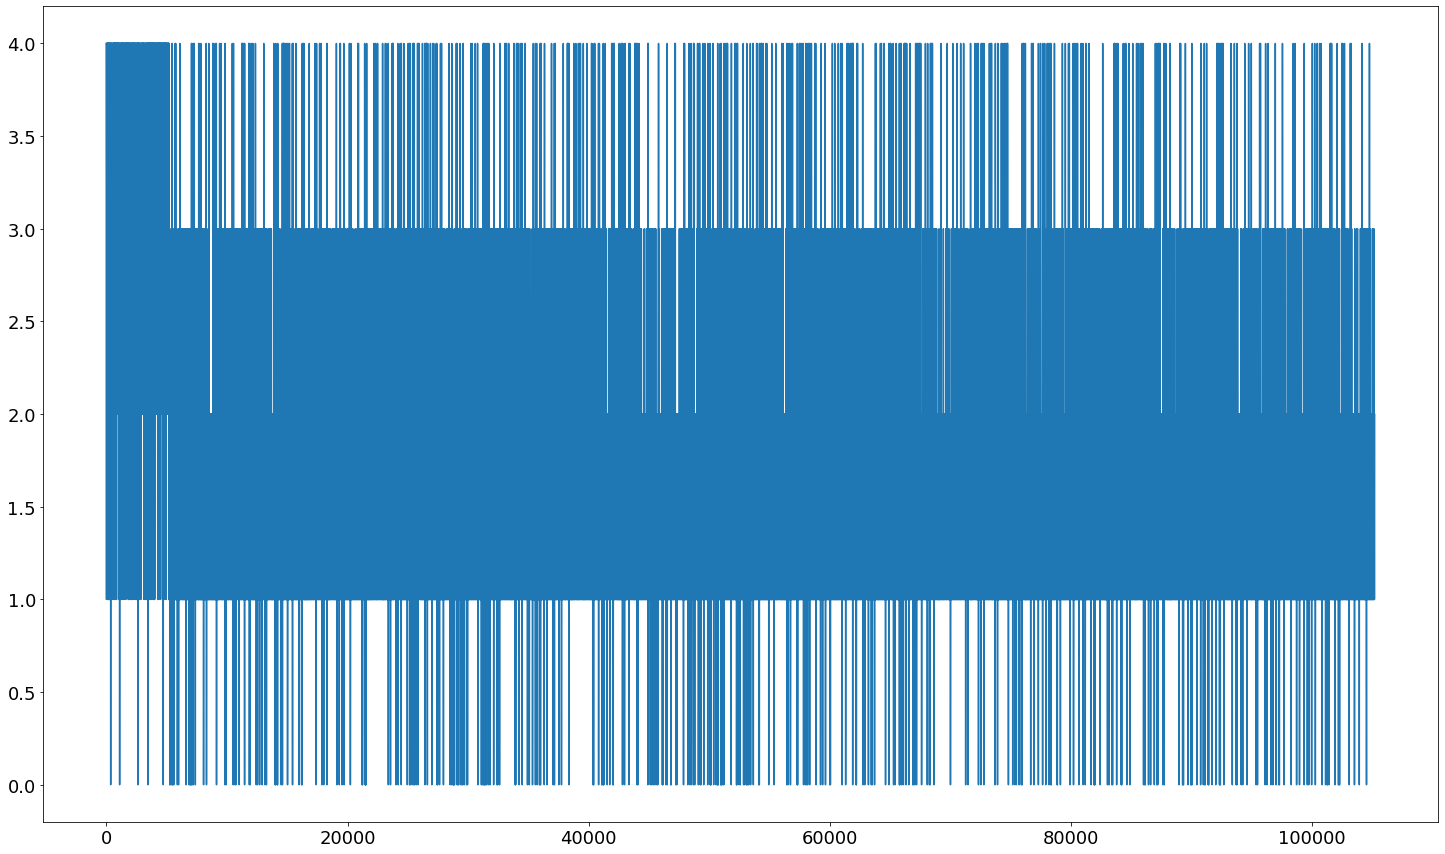

In [197]:
plt.plot(y_pred_ensemble.sum(axis=1))
plt.show()

In [172]:
ar39_1_features.iloc[:, [1, 3, 5, 7]].describe()

,meanpe_0,meanpe_1,meanpe_2,meanpe_3
count,99999.000000,99999.000000,99999.000000,99999.000000
mean,0.048441,0.048640,0.064708,0.063996
std,0.076930,0.077717,0.124317,0.121391
min,0.000000,0.000000,-0.027778,-0.027778
25%,0.000000,0.000000,-0.027778,-0.027778
50%,0.027778,0.027778,0.027778,0.027778
75%,0.055556,0.055556,0.125000,0.125000
max,1.166667,1.111111,1.136212,1.159593


In [173]:
ar39_3_features.iloc[:, [1, 3, 5, 7]].describe()

,meanpe_0,meanpe_1,meanpe_2,meanpe_3
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.145856,0.146616,0.274238,0.274147
std,0.133284,0.133931,0.202562,0.199582
min,0.000000,0.000000,-0.027778,-0.027778
25%,0.055556,0.055556,0.106014,0.111111
50%,0.111111,0.111111,0.271204,0.271887
75%,0.194444,0.194444,0.417625,0.415579
max,1.527778,1.722222,1.687698,1.816246


In [175]:
ar39_7_features.iloc[:, [1, 3, 5, 7]].describe()

,meanpe_0,meanpe_1,meanpe_2,meanpe_3
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.341784,0.341794,0.557426,0.556914
std,0.203878,0.203994,0.220507,0.216887
min,0.000000,0.000000,-0.027778,-0.027778
25%,0.194444,0.194444,0.424894,0.425411
50%,0.305556,0.305556,0.536198,0.536216
75%,0.444444,0.444444,0.673956,0.674016
max,2.027778,1.916667,2.071560,2.051386
